In [1]:
# -*- coding: utf-8 -*-
"""
Created on Wed Jun 23 14:32:10 2021

@author: S. Izgagin
"""
import numpy as np
from scipy import linalg

class TikhonovRegularization:
    
    A = np.matrix([[]])
    u = np.array([])
    C = 0
    h = 1E-5
    delta = 1E-5
    
    __a = 0
    __b = 0
    __N = 10
    __M = 10
    
    Imax = 400  #Максимальное количество итераций (для метода хорд)
    
    alpha = 0.0 #Выходной параметр, который можно считать после выполнения метода Solve()

    def __init__(self, A, u, s, t, h, delta, C=0):
        """
        Конструктор класса

        Parameters
        ----------
        A  : Matrix
            Матрица оператора, в которой M-строк и N-столбцов.
            N соответствует s, а M - t.
        h - Погрешность оператора.
        delta - Погрешность правой части уравнения Az=u.
        ht : Шаг сетки для u(t).
        hs : Шаг сетки для z(s).
        
        Returns
        -------
        None.

        """
        self.__N = len(s)
        self.__M = len(t)
        
        self.A = np.matrix(A)
        # if z != 0:
        #     self.z = z.reshape((N,1))
        self.u = np.reshape(u, (self.__M,1))

        self.h = h
        self.delta = delta
        
        self.__a = s[0]#a
        self.__b = s[-1]#b
        
        #Формирование массива сетки
        self.hs = np.average([s[j] - s[j - 1] for j in range(1,self.__N)])#(b - a) / N
        self.ht = np.average([t[i] - t[i - 1] for i in range(1,self.__M)])#(d - c) / M
        print("Average steps are hs =", self.hs, "ht =", self.ht)
        
        if C == 0:
            self.C = self.OptC()
        else:
            self.C = C
            


    def Solve(self):
        """
        Выполнение регуляризации по методу Тихонова.
        Используется метод хорд для нахождения alpha.
        Система линейных уравнений решается встроенным методом numpy.linalg.solve(A,u).

        Returns
        -------
        z_delta: 1D-array
            Приближенное решение обратной задачи по методу Тихонова.

        """
        #Вычисление верхней оценки alpha
        alpha_0 = self.AlphaTop()
        #Поиск минимального alpha методом хорд
        alpha_min = self.AlphaSearch(alpha_0)
        return self.EilerSolve(alpha_min)

    def sobol_norm2(self, z_a):
        """
        Вычисляет норму z в пространстве Соболева

        Parameters
        ----------
        z : 1D-array
            Массив значений z.

        Returns
        -------
        double
            Возвращает норму, вычисленную в пространстве Соболева

        """
        # n = len(z_a)
        # z = z_a
        # if z_a.shape == (n,1):
        #     z = z_a.flatten()
        # Z_sum = 0
        # z1 = 0
        # z2 = 0
        # for j in range(0, n):
        #     dz2 = 0.0
        #     if j == 0:
        #         dz2 = (z[j] - z[j]) / self.hs[0]
        #     else:
        #         dz2 = (z[j] - z[j - 1]) / self.hs[j]
        #     z1 += z[j] * z[j] * self.hs[j]
        #     z2 += dz2 * dz2 * self.hs[j]
        # Z_sum = z1 + z2
        n = len(z_a)
        z = z_a
        if z_a.shape == (n,1):
            z = z_a.flatten()
        Z_sum = 0
        z1 = (z * z).sum()
        z2 = 0
        for j in range(0, n):
            dz2 = 0.0
            if j == 0:
                dz2 = (z[j] - z[j]) / self.hs
            else:
                dz2 = (z[j] - z[j - 1]) / self.hs
            z2 += dz2 * dz2
        Z_sum = (z1 + z2) * self.hs
        return np.sqrt(Z_sum) 

    def NormU(self):
        """
        Возвращает  норму U

        Parameters
        ----------
        u : 1D-array
            Массив правой части.

        Returns
        -------
        double
            Возвращает число - норму u.
        """
        #return np.sqrt((self.u * self.u * self.ht).sum())
        return np.sqrt((self.u * self.u).sum() * self.ht)
    
    def OperatorNorm(self):
        """
        Рассчитывает норму оператора A

        Parameters
        ----------
        a : float
            Начало интервала интегрирования.
        b : float
            Конец интервала интегрирования.

        Returns
        -------
        double
            Возвращает норму оператора A.

        """
        # outIntegral = 0
        # for i in range(0, self.__M):
        #     innerIntegral = 0
        #     for j in range(0,self.__N):
        #         innerIntegral += self.A[i, j] * self.hs[j]
        #     outIntegral += innerIntegral*innerIntegral * self.ht[i]
        # return np.sqrt(1.0 / (self.__b - self.__a) * outIntegral)
        outIntegral = 0
        for i in range(0, self.__M):        #Цикл по строкам
            innerIntegral = 0               
            for j in range(0, self.__N):    #Цикл по столбцам
                innerIntegral += self.A[i, j] * self.hs
            outIntegral += innerIntegral * innerIntegral
        return np.sqrt(1.0 / (self.__b - self.__a) * outIntegral * self.ht)


    def AlphaTop(self):
        """
        Расчет верхней границы параметра регуляризации

        Returns
        -------
        Верхняя граница параметра регуляризации

        """
        #Оценочное значение alpha
        norm = self.OperatorNorm()
        alpha_es = (norm * norm * self.C * self.delta) / (self.NormU() - self.C * self.delta)
        return norm * (self.h + np.sqrt(self.h * self.h + (alpha_es + self.h * self.h) * (self.C * self.C - 1))/(self.C * self.C - 1))

    def OptC(self):
        """
        Находит оптимальное значение константы C как среднее значение
        между 1 и отношением ||u||/delta

        Parameters
        ----------
        u : 2D-np.array
            Массив значений правой части.
        delta : double, optional
            Погрешность правой части. The default is 1E-5.

        Returns
        -------
        Оптимальное значение константы C.

        """
        self.C = (self.NormU() / self.delta - 1.0) / 2.0
        return self.C

    def DiscrepancySquare(self, z):
        """
        Вычисляет квадрат невязки

        Parameters
        ----------
        operA : Matrix
            Матрица оператора.
            z : 1D-array
            Массив значений функции z.
            u : 1D-array
            Массив значений правой части с погрешностью.
            hs, ht: double
            Шаги интегрирования (рассчитываются при построении сетки).

        Returns
        -------
        D(t) : double
        Возвращает квадрат невязки на основе входных значений

        """
        #Считаем матрицу невязки
        matD = self.A * z * self.hs - self.u  
        
        #Мера несовместности при alpha = 0
        z0 = self.EilerSolve(0.0)
        matD0 = self.A * z0 * self.hs - self.u
        
        return ((matD.T * matD).sum() - (matD0.T * matD0).sum()) * self.ht

    def GeneralDiscrepancy(self, alpha):
        """
        Вычисляет обобщенную невязку для заданного alpha

        Parameters
        ----------
        operA : Matrix
            Матрица оператора.
            z_a : 1D-array
            Массив приближенных значений z.
        u_t : 1D-array
            Правая часть уравнения Az = u.
        alpha : double
           Значение параметра регуляризации.
        h : double, optional
            Погрешность оператора. The default is 1E-5.
            delta : double, optional
            Погрешность правой части уравнения Az = u. The default is 1E-5.

        Returns
        -------
        Возвращает числовое значение обобщенной невязки в точке z_a.

        """
        #Получаем приближенное решение для заданного alpha
        z_a = self.EilerSolve(alpha)
        #Рассчитываем обобщенную невязку
        return self.DiscrepancySquare(z_a) - (self.delta + self.h * self.sobol_norm2(z_a))**2
    

    def AlphaSearch(self, alpha_0, eps = 1E-5):
        """
        Находит значение параметра регуляризации
        по функции обобщенной невязки методом хорд

        Parameters
        ----------
        ro : function
            Функция обобщенной невязки.
            alpha_0 : double
            Стартовое значение параметра 'альфа'.
            eps : double, optional
            Параметр точности. The default is 10**-6.

        Returns
        -------
        alpha - искомое значение параметра регуляризации.

        """
        alpha_1 = alpha_0 / 2.0
        mu0 = 1.0 / alpha_0
        mu1 = 1.0 / alpha_1
        
        I = 1       #Количество выполненных итераций цикла
        while ((np.abs(mu0 - mu1) >= eps) and (I < self.Imax)):
            I += 1
            #print("Alpha search... Iteration", I,end=' ')
            ro0 = self.GeneralDiscrepancy(1.0 / mu0)
            ro1 = self.GeneralDiscrepancy(1.0 / mu1)
            #Старое выражение для alpha
            #alpha_n = alpha_0 / (1.0 - (1.0 - alpha_0/alpha_1) * (ro0 / (ro0 - ro1)))
            mu_n = mu0 - (mu0 - mu1) * ro0 / (ro0 - ro1)
            if ro0 * ro1 > 0:
                mu0 = mu1
                mu1 = mu_n
            if ro0 * ro1 < 0:
                roN = self.GeneralDiscrepancy(1.0 / mu_n)
                if ro0 * roN < 0:
                    mu1 = mu_n
                if ro1 * roN < 0:
                    mu0 = mu_n
            #print("\rAlpha search... Iteration", I, "Done!")
        if I >= self.Imax:
            print("Цикл был прерван из-за превышения количества итераций")
        self.alpha = 1.0 / mu1
        print("Количество итераций = ", I, "| alpha* = ", self.alpha)
        return self.alpha
    
    def Q_matrix(self):
        # I = 0
        # for i in range(0, self.__M):
        #     I_buf = 0
        #     for j in range(0, self.__N):
        #         I_buf += self.A[j,i] * self.A[i,j]
        #     I += I_buf * self.ht[i]
        # return I
        return self.A.T * self.A * self.ht
    
    def B_matrix(self):
        return self.Q_matrix() * self.hs
    
    def EilerSolve(self, alpha):
        B = self.B_matrix()
        B_r = self.B_right()
        B_a = B + alpha * B_r
        
        G = self.ht * self.A.T * self.u
        z_a = linalg.solve(B_a, G)
        #z_a = self.SquareRootMethod(B_a, G)
        return z_a
        
    def C_matrix(self):
        """
        Создает диагональную матрицу, у которой главная диагональ = 2, соседние диагонали = -1.
        Элементы C[0,0] = C[n,n] = 1
        """
        n = self.__N
        C = np.eye(n,n,k=0) + np.eye(n,n,k=0) - np.eye(n,n,k=1) - np.eye(n,n,k=-1)
        C[0,0] = 1.0
        C[-1,-1] = 1.0
        return C
    
    def B_right(self):
        E = np.eye(self.__N, self.__N,k=0)
        C = self.C_matrix()
        return E + 1.0 / (self.hs * self.hs) * C
    
        #Метод не работает, т.к. в матрице T появляются значения inf и nan
    def SquareRootMethod(self, Bmat, G):
        """
        Решение системы уравнений методом квадратного корня

        Returns
        -------
        None.

        """ 
        n = len(Bmat)
        Tmat = np.zeros((n,n))                  #Выделяем память под матрицу
        Tmat[0,0] = np.sqrt(Bmat[0,0])          #Заполняем первый элемент
        for j in range(1,n):                    
            Tmat[0,j] = Bmat[0,j] / Tmat[0,0]   #Заполняем первую строку
            
        #Заполняем оставшиеся ячейки    
        for i in range(1,n):
            for j in range(0,n):  
                if i > j:
                    Tmat[i,j] = 0.0
                else:
                    if i == j:
                        sum = 0.0
                        for k in range(0,i):
                            sum += Tmat[k,i] * Tmat[k,i]
                        if Bmat[i,i] == sum:
                            Tmat[i,i] = 0.0
                        else:
                            Tmat[i,i] = np.sqrt(Bmat[i,i] - sum)
                        if np.isnan(Tmat[i,i]):
                            print("Tmat[{0},{0}] = nan. Bmat[{0},{0}] = {1}. sum = {2}".format(i,Bmat[i,i], sum))
                    if i < j:
                        sum = 0.0
                        for k in range(0,i):
                            sum += Tmat[k,i] * Tmat[k,j]
                        Tmat[i,j] = (Bmat[i,j] - sum) / Tmat[i,i]
        #print(Tmat)
        #Решение системы уравнений и получение z_a
        z_a = linalg.solve(np.transpose(Tmat) * Tmat, G)            
        return z_a

C:\Users\1\AppData\Local\Temp\ipykernel_9256\3732955867.py:48: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if ((type(t) == type(s)) != np.array([])):
C:\Users\1\AppData\Local\Temp\ipykernel_9256\3732955867.py:31: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if type(s) != np.array([]):
C:\Users\1\AppData\Local\Temp\ipykernel_9256\3377457582.py:349: LinAlgWarning: Ill-conditioned matrix (rcond=3.51034e-20): result may not be accurate.
  z_a = linalg.solve(B_a, G)


Average steps are hs = 0.02040816326530612 ht = 0.05263157894736842
Количество итераций =  12 | alpha* =  0.014151714697544332
C =  15.378703659248604 | AlphaTop =  0.4189644575712529
z_delta =  [0.48286975 0.4832097  0.48388645 0.48489664 0.48623665 0.48790258
 0.48989026 0.49219518 0.49481248 0.49773692 0.50096287 0.50448425
 0.50829449 0.51238655 0.51675282 0.52138511 0.52627462 0.53141188
 0.53678671 0.54238817 0.54820455 0.55422324 0.56043076 0.56681264
 0.57335341 0.58003651 0.58684422 0.59375762 0.6007565  0.60781929
 0.61492298 0.62204304 0.62915332 0.636226   0.64323146 0.65013819
 0.65691268 0.66351935 0.66992038 0.67607564 0.68194253 0.68747588
 0.6926278  0.69734753 0.70158131 0.70527221 0.70835998 0.71078086
 0.71246743 0.71334838]
Calculation time is 0.01666998863220215 sec



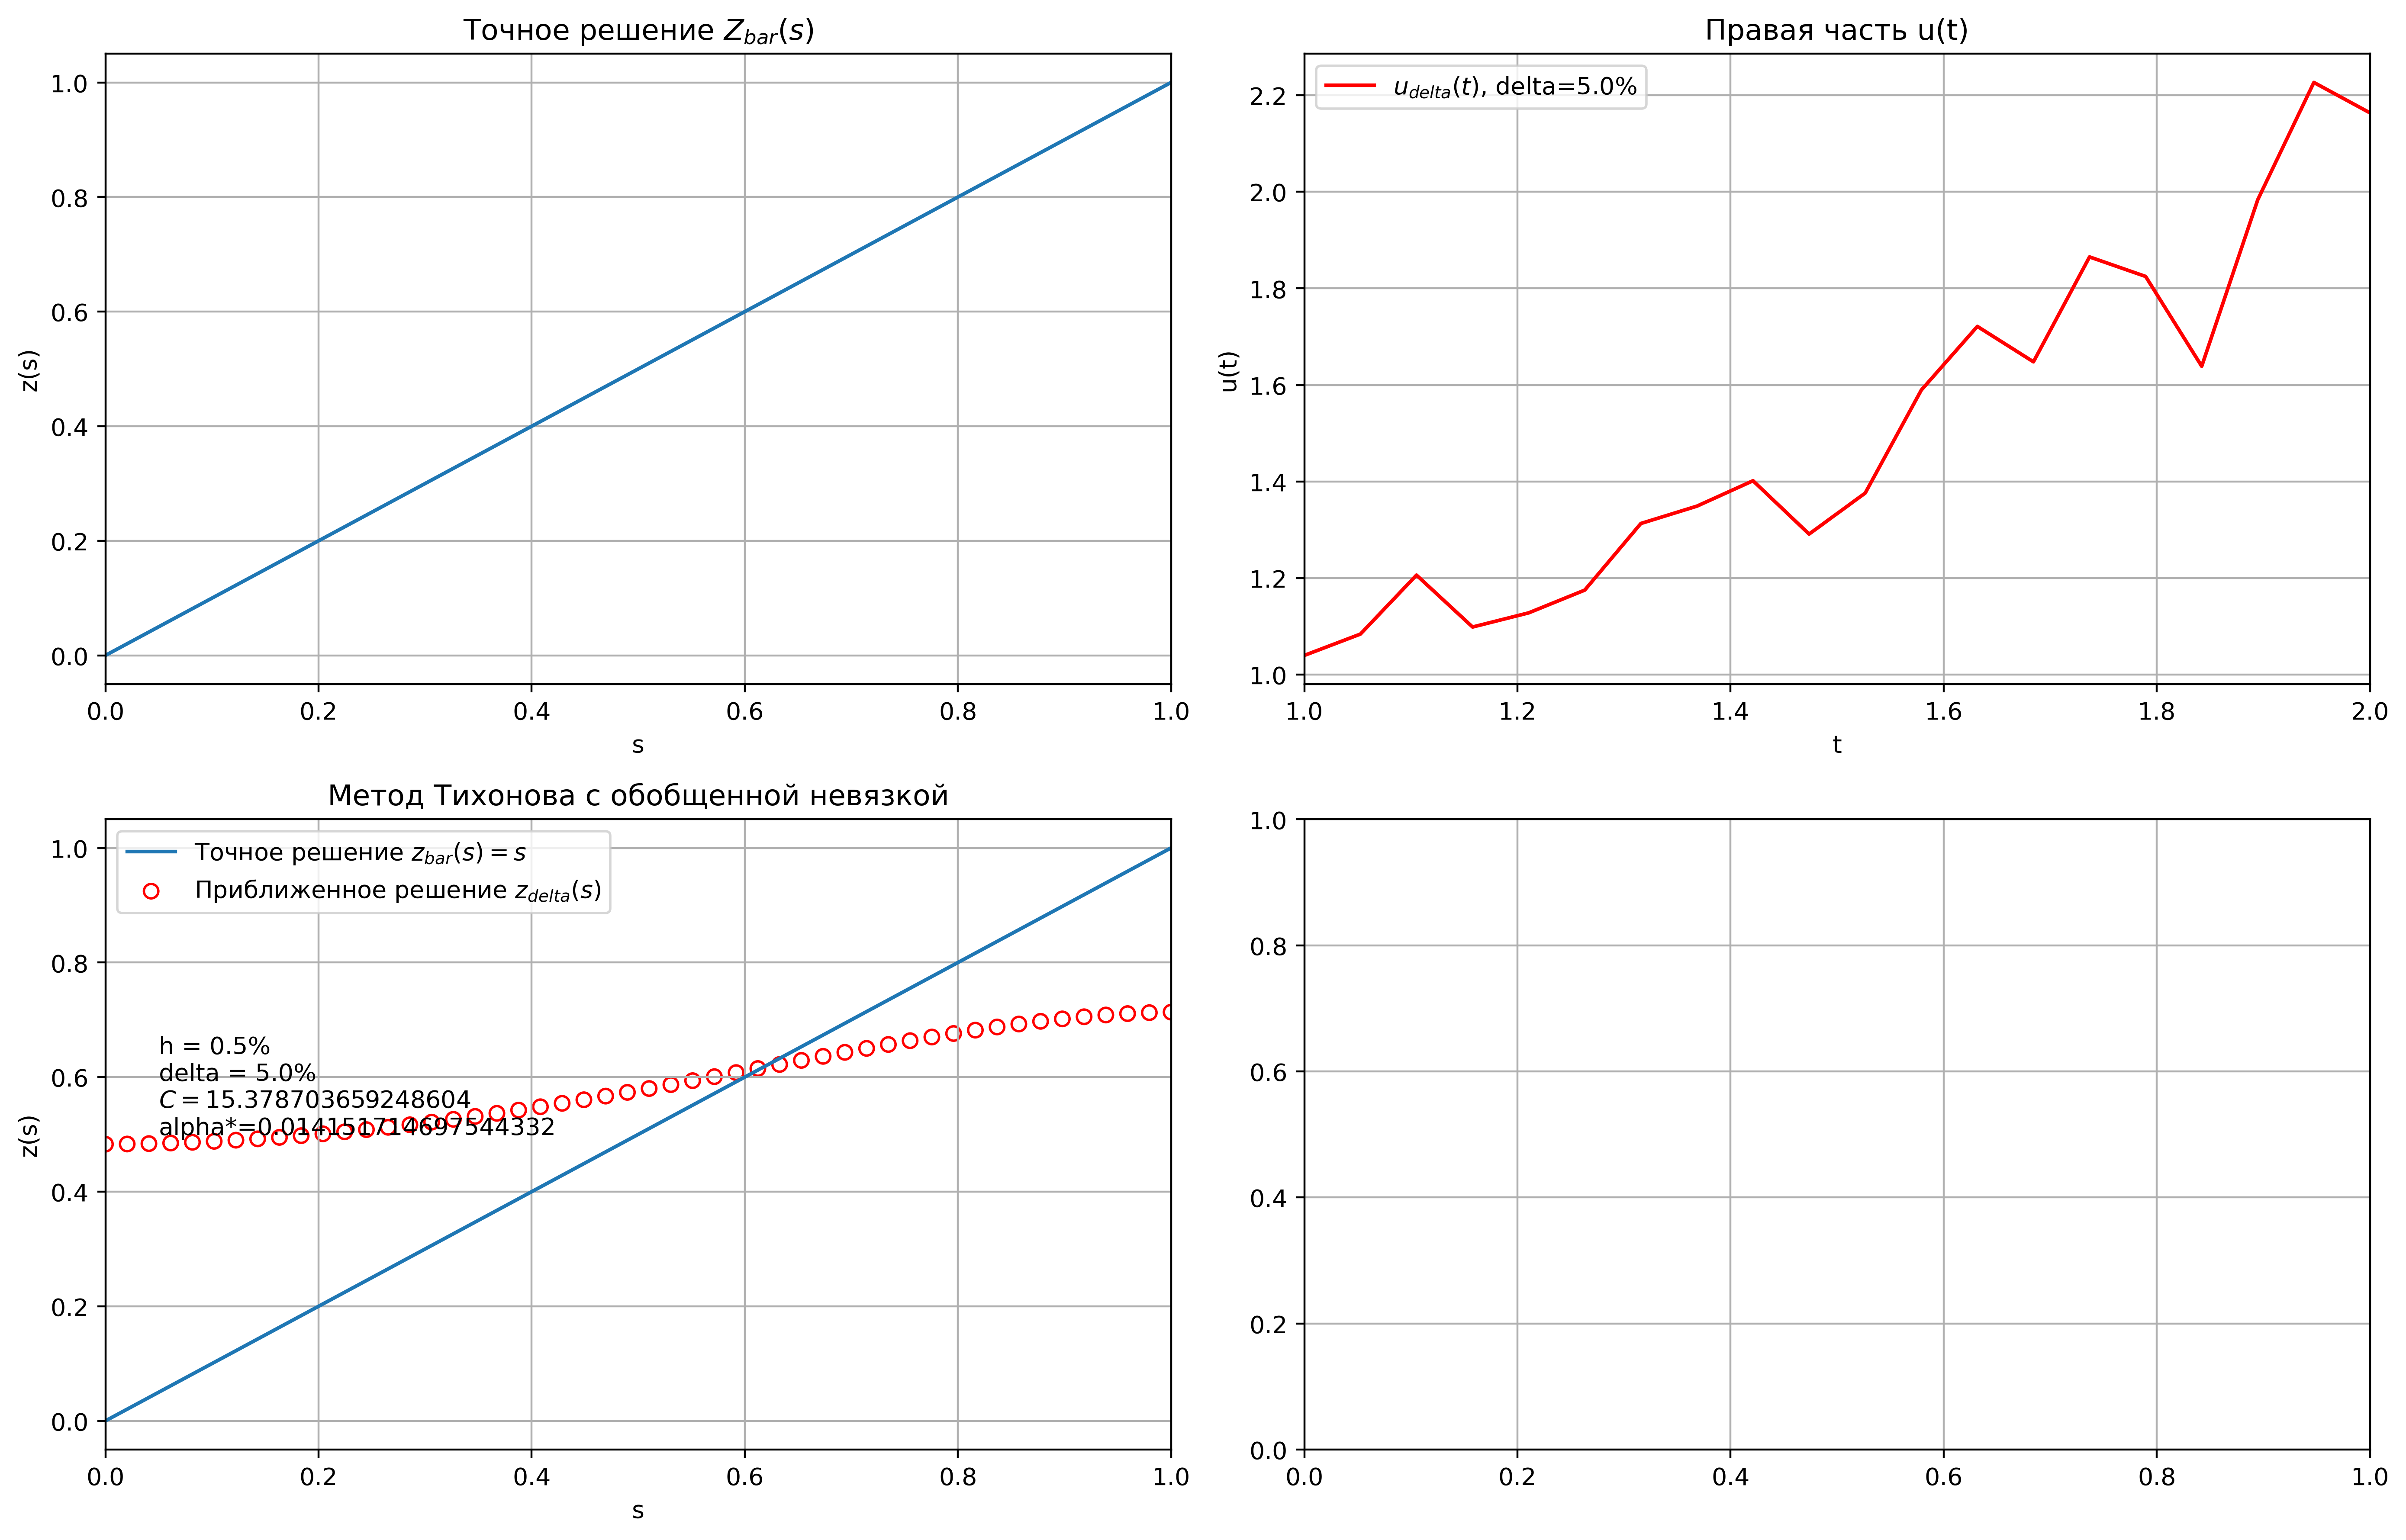

In [2]:
# -*- coding: utf-8 -*-
"""
Created on Mon Jun 21 21:24:33 2021

@author: S. Izgagin
"""
import time
import numpy as np
import matplotlib.pyplot as plt

def Zbar(s):
    #return 1.0 - s * s
    return s
    #return 4 * s * (1.0 - s)
    #return 0.9550408 * (np.exp(-(s - 0.3)**2 / 0.03) + np.exp(-(s - 0.7)**2 / 0.03)) - 0.052130913

def ZbarPowerTo2(s):
    return Zbar(s)*Zbar(s)

def Kernel(t,s):
    return np.exp(t * s)
    #return 1.0 / (1.0 + 100.0 * (s - t) * (s - t))

def Ubar(t):
    return 1.0 / (t * t) * (1.0 + (t - 1.0) * np.exp(t))

"""
Плюралистические функции
"""
def Z(s):
    if type(s) != np.array([]):
        return Zbar(s)
    z_out = []
    for sj in s:
        z_out.append(Zbar(sj))
    return z_out

def U(t):
    if (type(t) != np.array([])):
        return Ubar(t)
    U_out = []
    for ti in t:
        U_out.append(Ubar(ti))
    return U_out


def K(t,s):
    if ((type(t) == type(s)) != np.array([])):
        return Kernel(t,s)
    K_out = []
    for ti in t:
        a = []
        for sj in s:
            a.append(Kernel(ti,sj))
        #a[0] /= 2
        #a[-1] /= 2
        K_out.append(a)
    return np.matrix(K_out)

#==============================Входные параметры===============================
delta = 5E-2
h = 5E-3
C = 0
a, b = 0.0, 1.0
c, d = 1.0, 2.0
N, M = 50, 20

#=============================Расчет===========================================
#Расчет шага сетки, формирование сетки, чтение функций z_bar и Kernel
hs = (b-a) / N
s = np.linspace(a,b,N)                                    #Сетка по переменной s
t = np.linspace(c,d,M)                                    #Сетка по переменной t
Kernel = K(t,s)
z_bar = Z(s)
#u = SFunc.U(t)                                           #Массив значений право части задается прямым вычислением в каждой узловой точке
u = (Kernel * np.transpose([z_bar])).getA1() * hs            #Массив значений правой части задается умножением матрицы оператора K(t,s) на известную правую часть z
u_delta = u + np.random.normal(0.0, u.max() * delta, M)      #Добавляем возмущение к правой части

#=============================Чтение данных из файла=========================
#Kernel, u_delta, s, t = FileReader.ReadExcelFile("Test_uni.xlsx", operatorCols=[0,1,2,3,4], uCol = 6, tCol = 12, sCol = 10)
#Kernel = Kernel.T   #Транспонируем ядро, чтобы размеры матрицы соответствовали требованию: m-строк, n-столбцов
#a, b = s[0], s[-1]
#c, d = t[0], t[-1]
#N, M = len(s), len(t)

start_time = time.time()                                    #Засекаем начало длительности расчета
#Создание объекта класса для Тихоновской регуляризации
tikhonov = TikhonovRegularization(Kernel, u_delta, s, t, h=h, delta=delta, C = C)
z_delta = tikhonov.Solve().flatten()                        #Приближенное решение

#===========================Печать результатов================================
print("C = ", tikhonov.C, "| AlphaTop = ", tikhonov.AlphaTop())
#print("Kernel(t,s) =\n",Kernel, "\n")
#print("z_bar = ", z_bar)
print("z_delta = ", z_delta)
print("Calculation time is", time.time()-start_time,"sec\n")
#np.savetxt("z_delta.txt",z_delta)               #Сохранение приближенного решения в файл

#============================Построение графиков=============================
fig, ax = plt.subplots(2,2)
fig.set_figheight(9)
fig.set_figwidth(14)
fig.set_dpi(400)

ax[0,0].set(title='Точное решение $Z_{bar}(s)$', xlabel='s', ylabel='z(s)', xlim=(a,b))
ax[0,0].plot(s,z_bar)
ax[0,0].grid(True)

ax[0,1].set(title='Правая часть u(t)', xlabel='t', ylabel='u(t)', xlim=(c,d))
ax[0,1].plot(t, u_delta, color='red')
ax[0,1].legend(['$u_{delta}(t)$, delta=' + str(delta*100)+'%'])
ax[0,1].grid(True)

ax[1,0].set(title='Метод Тихонова с обобщенной невязкой', xlabel='s', ylabel='z(s)')
ax[1,0].set_xlim((a,b)) 
#ax[1,0].set_ylim((z.min(),z.max()))
ax[1,0].plot(s,z_bar)
ax[1,0].scatter(s,z_delta, marker='o', facecolors='none', edgecolors='red')
ax[1,0].legend(['Точное решение $z_{bar}(s) = s$', 'Приближенное решение $z_{delta}(s)$'])
ax[1,0].grid(True)
ax[1,0].text(0.05,0.5,'h = '+str(h*100.0) + '%' +'\ndelta = '+str(delta*100)+'%'+'\n$C='+str(tikhonov.C)+'$\nalpha*=' + str(tikhonov.alpha))

# ax[1,1].set(title='Правая часть u(t): 1) u = U(t), 2) u = K(s,t) * z(s)', xlabel='t', ylabel='u(t)')
# ax[1,1].set_xlim((c,d))
# ax[1,1].plot(t,SFunc.U(t), linewidth=1)
# ax[1,1].plot(t,u, color='red', linewidth=1)
# ax[1,1].legend(['$U(t)$', '$K(t,s) * z(s)$'])
ax[1,1].grid(True)

fig.tight_layout()
#fig.subplots_adjust(wspace=0.2, hspace=0.3)
